This notebook is used to postprocessing the inverse modeling results of the cloud chamber model.

In [1]:
# Libraries
from pathlib import Path
import pandas as pd
import numpy as np

from kim.map import KIM
from kim.data import Data
from kim.mapping_model import MLP
from kim.utils import plot_sensitivity_mask, plot_sensitivity

import jax

%load_ext autoreload
%autoreload 2
%matplotlib inline 


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Plotting parameters
# rc('text', usetex=False)
small_size = 15
medium_size = 25
bigger_size = 30
plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=small_size)    # fontsize of the axes title
plt.rc('axes', labelsize=small_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_size)    # legend fontsize
plt.rc('figure', titlesize=small_size)  # fontsize of the figure title
plt.rc('text', usetex = False)



In [5]:
jax.devices()

[CpuDevice(id=0)]

# Read the data

In [6]:
# File and folder paths
dir_case = Path("/people/jian449/KIM/examples/im_cloudmodel")
f_para = dir_case / "data" / "Output_512.csv"
f_state = dir_case / "data" / "Input_512.csv"
# f_para = Path("./data/Output_512.csv")
# f_state = Path("./data/Input_512.csv")


In [7]:
df_para, df_state = pd.read_csv(f_para),pd.read_csv(f_state)

In [8]:
y_vars, x_vars = df_para.keys().to_list(), df_state.keys().to_list()
y, x = df_para.values, df_state.values

y_vars = ['$\lambda_w$', '$\log_{10}(\lambda_c)$']

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_26913/2923420360.py:4: SyntaxWarning: invalid escape sequence '\l'
  y_vars = ['$\lambda_w$', '$\log_{10}(\lambda_c)$']
/tmp/ipykernel_26913/2923420360.py:4: SyntaxWarning: invalid escape sequence '\l'
  y_vars = ['$\lambda_w$', '$\log_{10}(\lambda_c)$']


In [9]:
x.shape, y.shape

((513, 1458), (513, 2))

# Load the preliminary analysis results

In [10]:
# f_data_save = Path("./results/data")
f_data_save = dir_case / "results/data"
data = Data(x, y)
data.load(f_data_save)


# Plot the sensitivity analysis results

[Text(0.5, 1.0, 'Global sensitivity')]

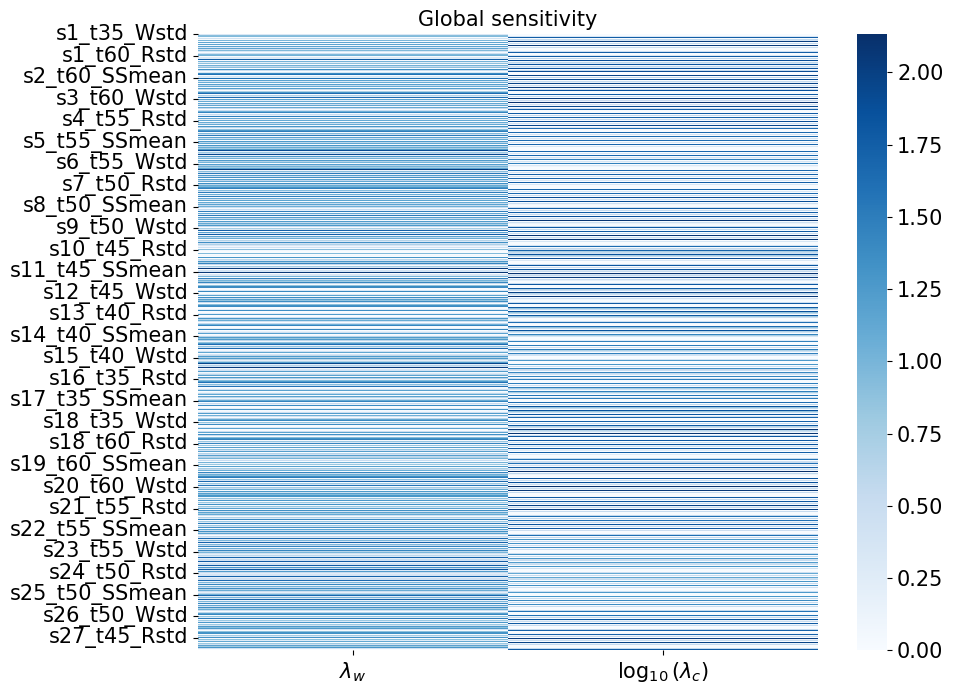

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_sensitivity(data.sensitivity, xlabels=x_vars, ylabels=y_vars)
ax.set(title='Global sensitivity')


[Text(0.5, 1.0, 'Global sensitivity mask')]

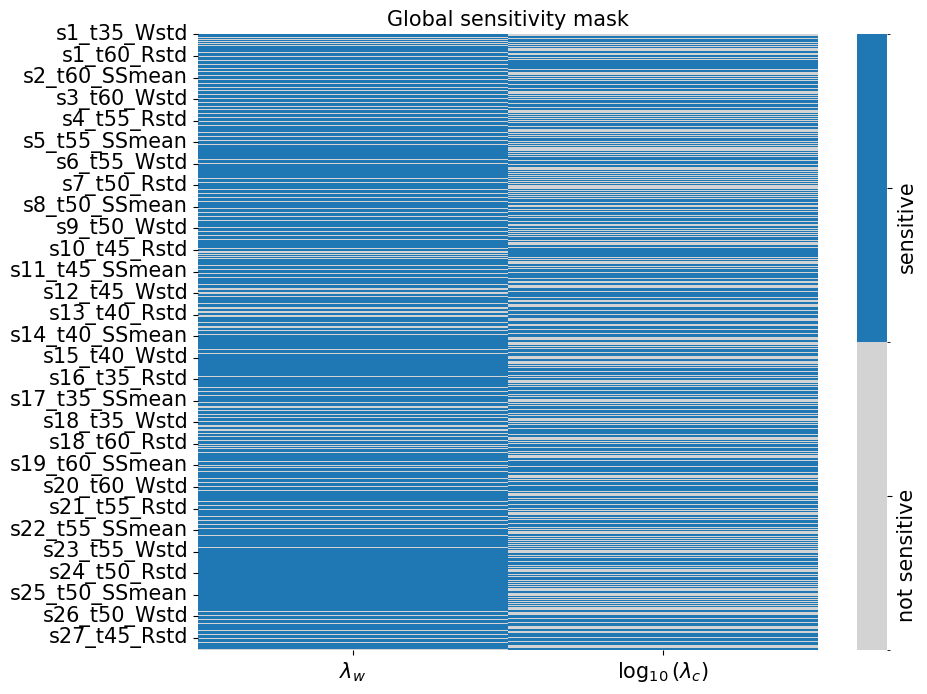

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_sensitivity_mask(data.sensitivity_mask, xlabels=x_vars, ylabels=y_vars)
ax.set(title='Global sensitivity mask')


In [13]:
data.cond_sensitivity_mask.sum(axis=0)

array([943, 545])

[Text(0.5, 1.0, 'Global sensitivity + Redundancy filtering mask')]

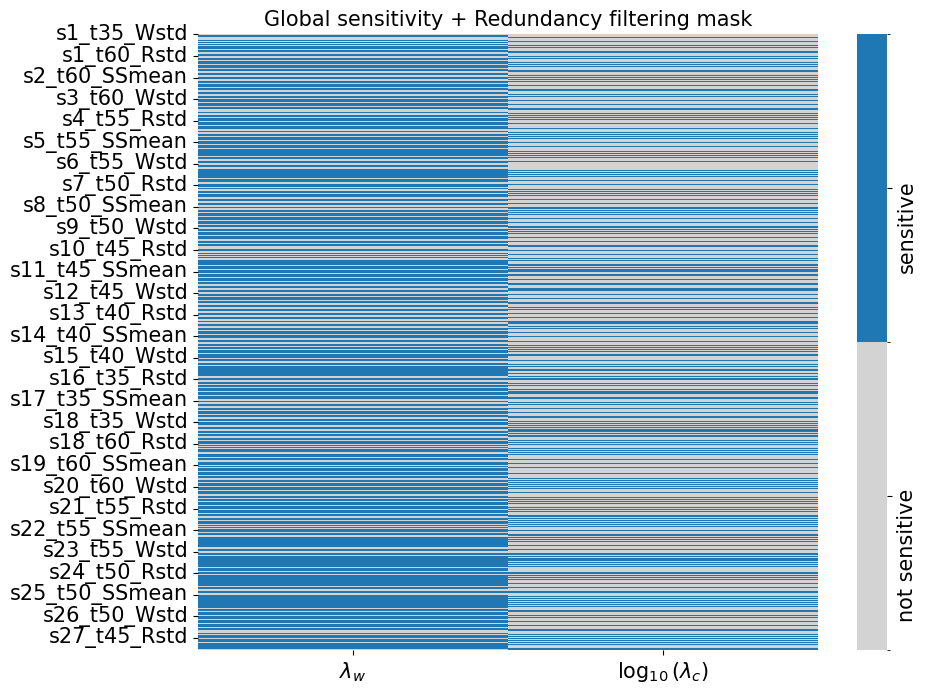

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_sensitivity_mask(data.cond_sensitivity_mask, xlabels=x_vars, ylabels=y_vars)
ax.set(title='Global sensitivity + Redundancy filtering mask')


## Plots specific to cloud chamber system

In [15]:
# Let's make a big pandas dataframe
loc = [int(xv.split('_')[0][1:]) for xv in x_vars]
time = [int(xv.split('_')[1][1:]) for xv in x_vars]
varn = [xv.split('_')[2] for xv in x_vars]
df_sen = pd.DataFrame()
df_sen['loc']  = loc
df_sen['time'] = time
df_sen['varn'] = varn
for i,yvarn in enumerate(y_vars):
    df_sen[yvarn] = data.sensitivity[:,i]
    df_sen[yvarn+"_mask"] = data.sensitivity_mask[:,i]
    df_sen[yvarn+"_condmask"] = data.cond_sensitivity_mask[:,i]    

varn_set = sorted(list(set(varn)))
time_set = sorted(list(set(time)))
loc_set = sorted(list(set(loc)))

# Set up the gradual changing color lines
# cmap = plt.cm.gist_rainbow  # You can choose other colormaps like 'plasma', 'inferno', 'magma', etc.
# colors = cmap(np.linspace(0, 1, len(loc_set)))

cmap1 = plt.cm.Blues_r
colors1 = cmap1(np.linspace(0.2, 0.8, 9))
cmap2 = plt.cm.Oranges_r
colors2 = cmap2(np.linspace(0.2, 0.8, 9))
cmap3 = plt.cm.Greys_r
colors3 = cmap3(np.linspace(0.2, 0.8, 9))
colors = np.concat([colors1, colors2, colors3])


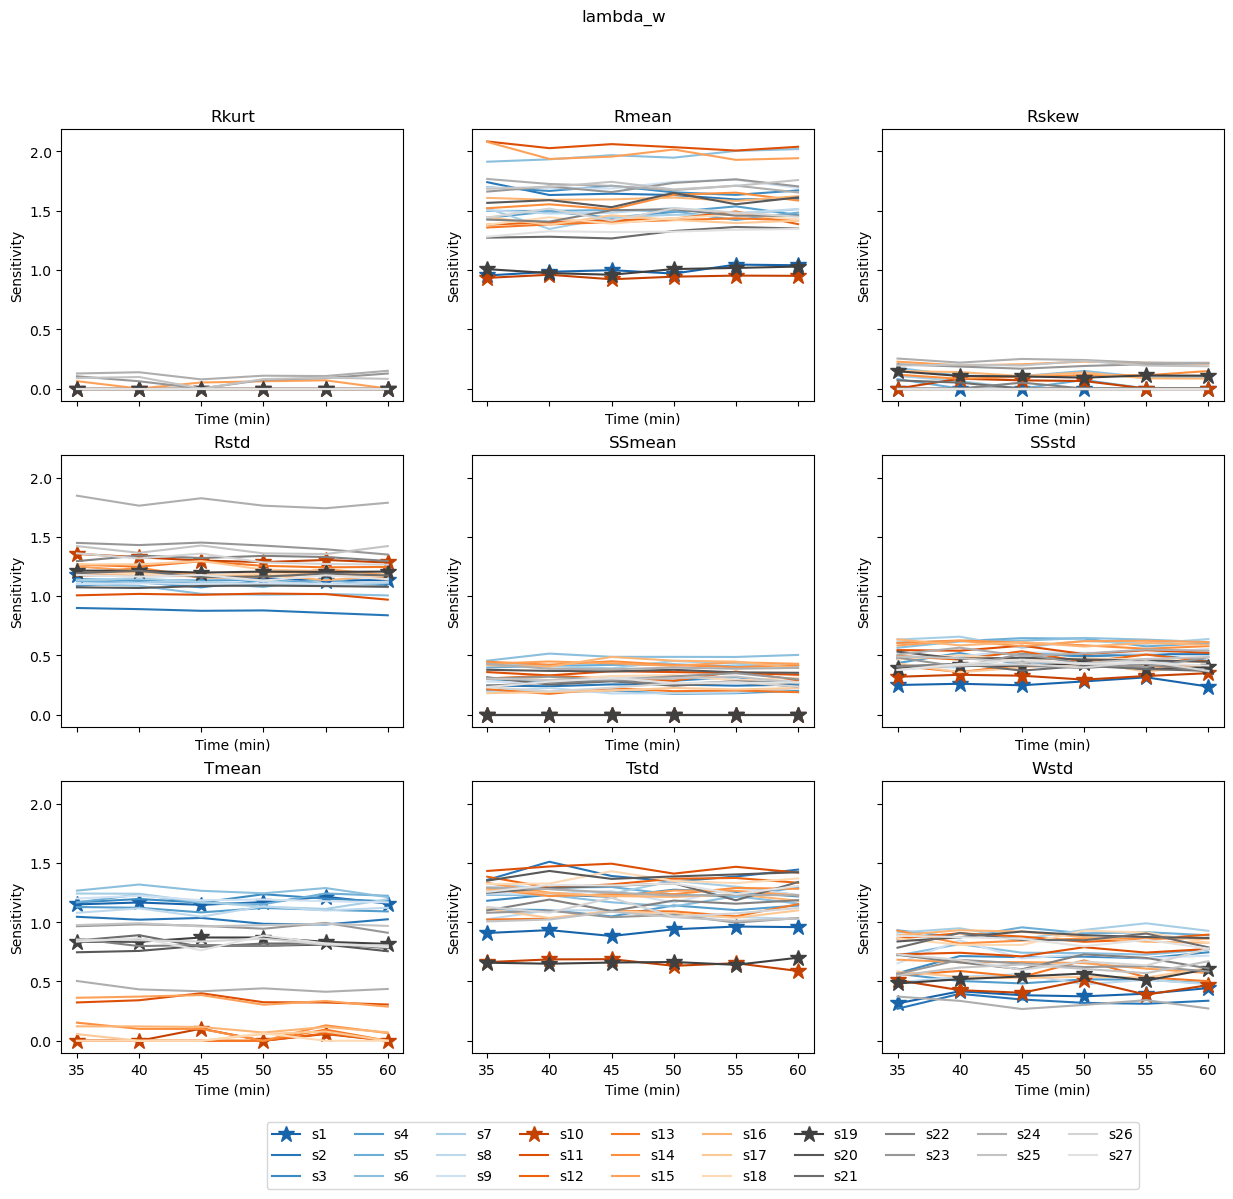

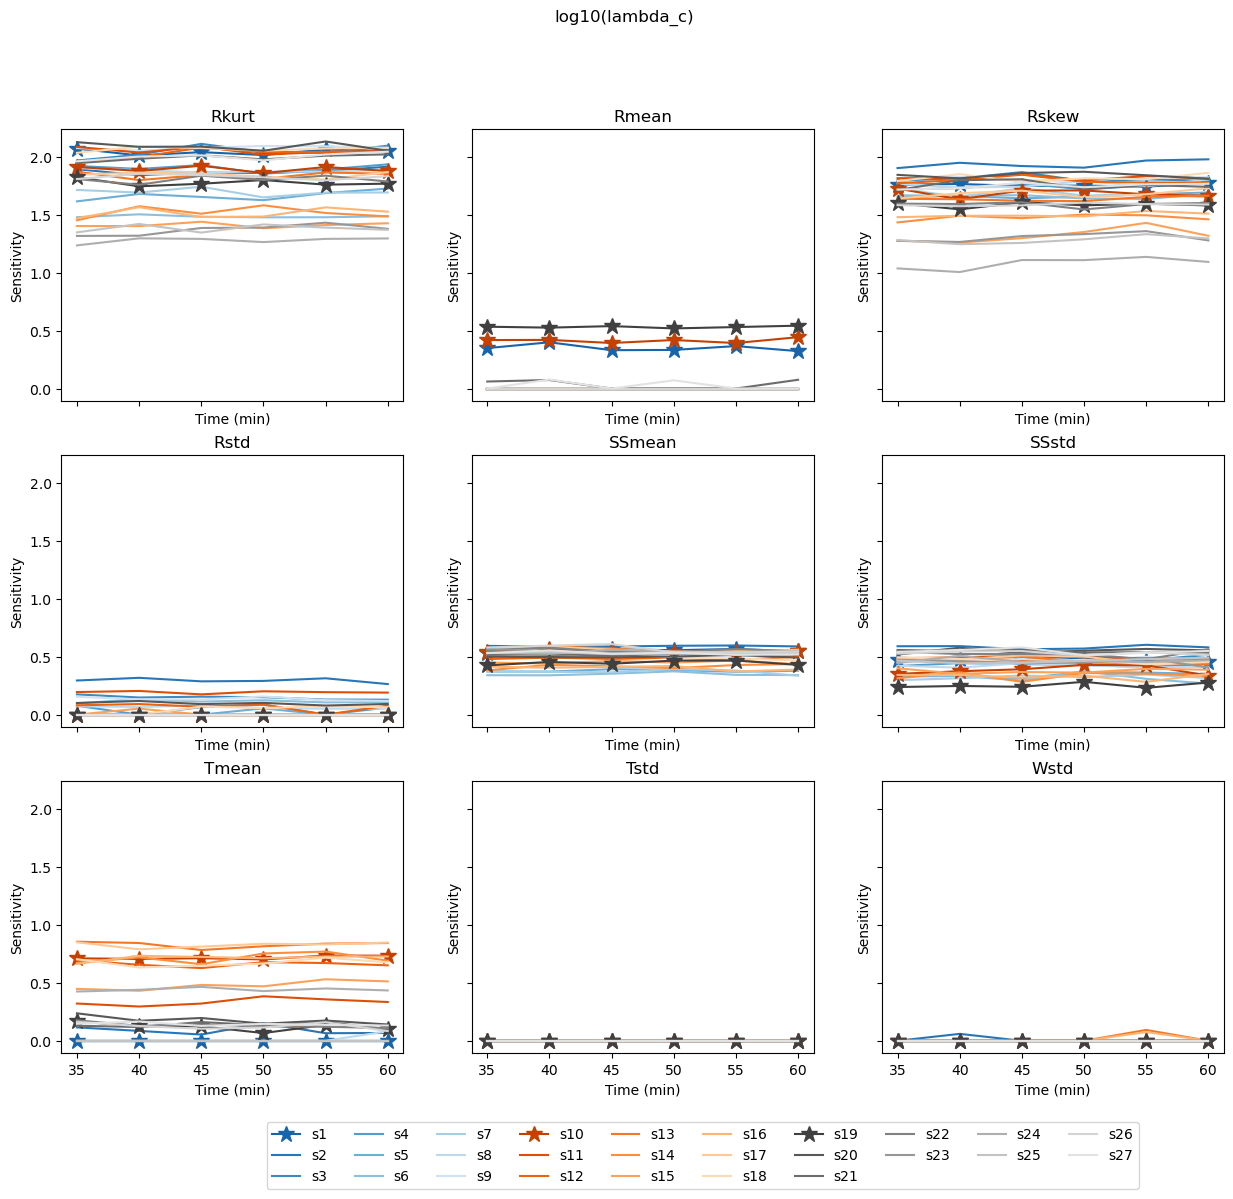

In [16]:
# Plot -- sensitivity only
for k,yvarn in enumerate(y_vars):
    fig, axes = plt.subplots(3, 3, figsize=(15,12), sharex=True, sharey=True)
    axes = axes.flatten()
    for i,varn in enumerate(varn_set):
        ax = axes[i]
        for j,loc in enumerate(loc_set):
            df = df_sen[(df_sen['varn']==varn) & (df_sen['loc']==loc)]
            t, d = df['time'].values, df[yvarn].values
            if loc in [1, 10, 19]:
                ax.plot(t, d, '-*', label=f"s{loc}", markersize=12, color=colors[j])
            else:
                ax.plot(t, d, label=f"s{loc}", color=colors[j])
        ax.set(title=varn, xlabel='Time (min)', ylabel='Sensitivity')
    ax.legend(loc=[-1.8, -0.5], ncols=10)
    plt.suptitle(yvarn)


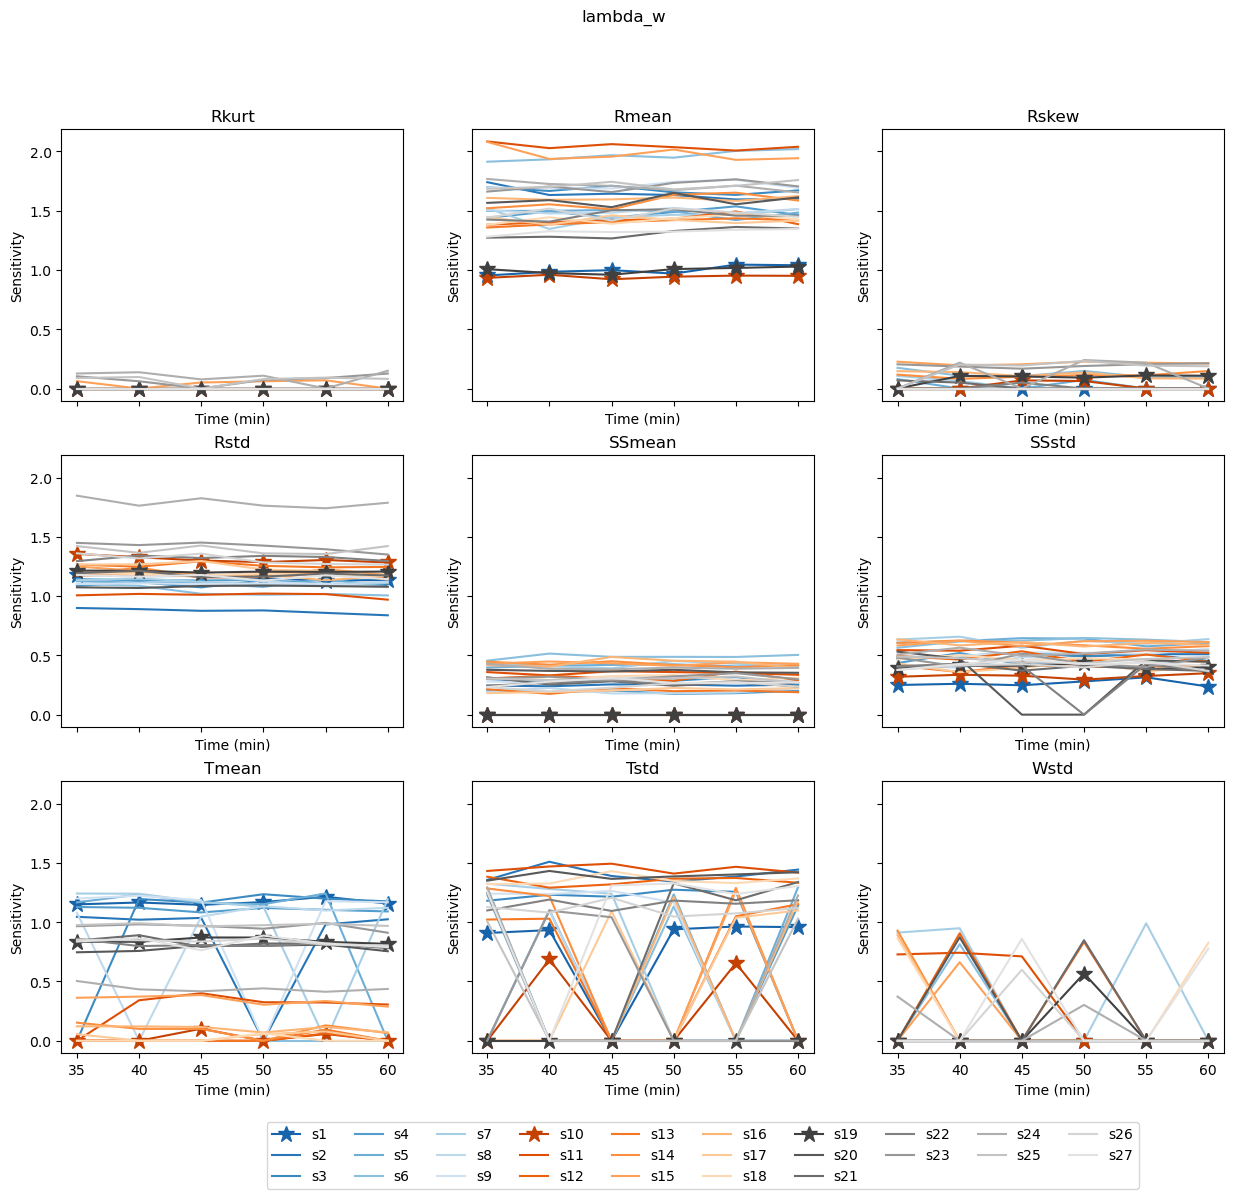

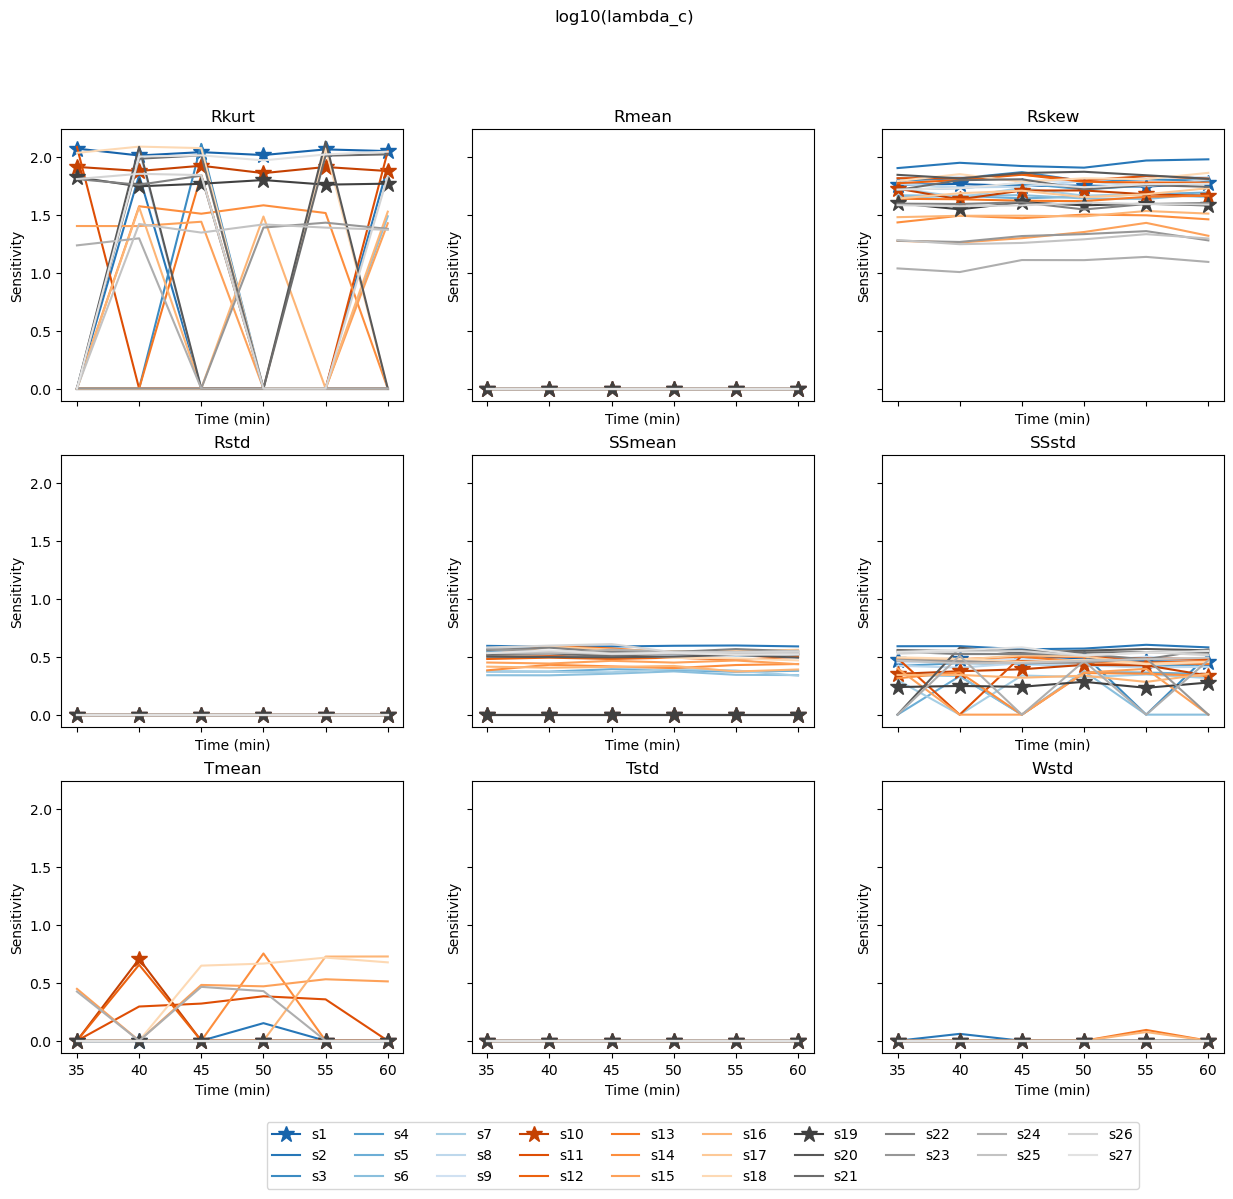

In [17]:
# Plot -- sensitivity filtered by conditional mask
for k,yvarn in enumerate(y_vars):
    fig, axes = plt.subplots(3, 3, figsize=(15,12), sharex=True, sharey=True)
    axes = axes.flatten()
    for i,varn in enumerate(varn_set):
        ax = axes[i]
        for j,loc in enumerate(loc_set):
            df = df_sen[(df_sen['varn']==varn) & (df_sen['loc']==loc)].copy()
            t, d = df['time'].values, df[yvarn].values
            m = df[yvarn+'_condmask']
            d[~m] = 0 
            if loc in [1, 10, 19]:
                ax.plot(t, d, '-*', label=f"s{loc}", markersize=12, color=colors[j])
            else:
                ax.plot(t, d, label=f"s{loc}", color=colors[j])
        ax.set(title=varn, xlabel='Time (min)', ylabel='Sensitivity')
    ax.legend(loc=[-1.8, -0.5], ncols=10)
    plt.suptitle(yvarn)


# Load the mapping results

In [18]:
f_kim_save1 = dir_case / "results/map_many2many"
f_kim_save2 = dir_case / "results/map_many2one"
f_kim_save3 = dir_case / "results/map_many2one_cond"


In [19]:
# Initialize three diffferent KIMs
kim1 = KIM(data, map_configs={}, map_option='many2many')
kim2 = KIM(data, map_configs={}, mask_option="sensitivity", map_option='many2one')
kim3 = KIM(data, map_configs={}, mask_option="cond_sensitivity", map_option='many2one')

# Load the trained mappings
kim1.load(f_kim_save1)
kim2.load(f_kim_save2)
kim3.load(f_kim_save3)


In [20]:
print(np.mean([loss[-1] for loss in kim1.maps[0].loss_val_ens]))
print(np.mean([loss[-1] for loss in kim2.maps[0].loss_val_ens]))
print(np.mean([loss[-1] for loss in kim3.maps[0].loss_val_ens]))
# kims = [kim1, kim2, kim3]


0.033201035
0.014794481
0.0062475116


In [21]:
# Calculate the performance metrics
kims = [kim1, kim2, kim3]
labels = ['kim1', 'kim2', 'kim3']
results = {}
for i,kim in enumerate(kims):
    label = labels[i]
    results[label] = kim.evaluate_maps_on_givendata()

# y_ens_train_set, y_ens_test_set, y_mw_train_set, y_mw_test_set, y_true_train_set, y_true_test_set, \
#     rmse_train_set, rmse_test_set, mkge_train_set, mkge_test_set = \
#     [], [], [], [], [], [], [], [], [], []
# for kim in kims:
#     y_ens_train, y_ens_test, y_mw_train, y_mw_test, rmse_train, \
#         y_true_train, y_true_test, rmse_test, mkge_train, mkge_test = kim1.evaluate_maps_on_givendata()
#     y_ens_train_set.append(y_ens_train)
#     y_ens_test_set


/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:80: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:126: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:80: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:126: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:80: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:126: RuntimeWarning: invalid value encountered in divi

# Plot the training results

## Prediction versus true

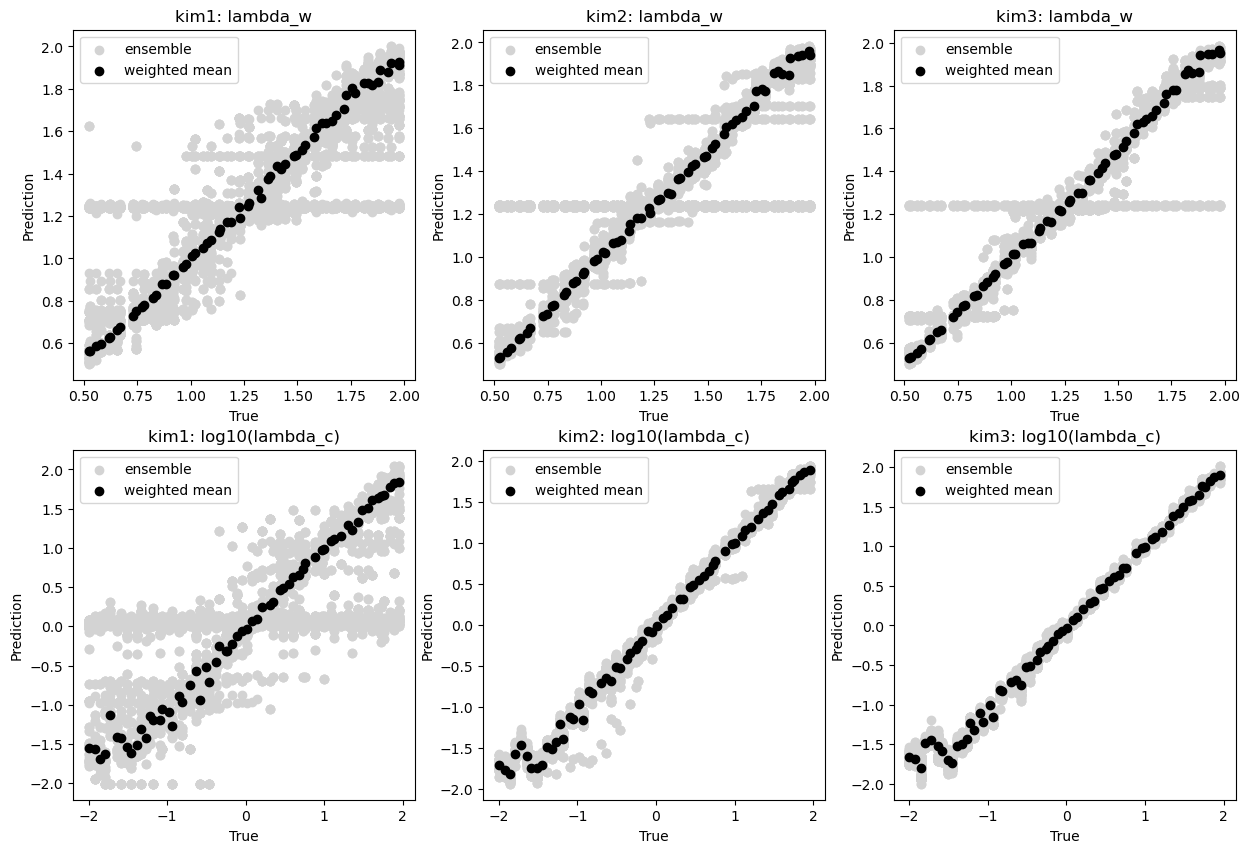

In [23]:
train_or_test = 'test'
fig, axes = plt.subplots(2,3,figsize=(15,10))
for i in range(2):
    y_var = y_vars[i]
    for j in range(3):
        model = labels[j]
        r = results[model]
        ax = axes[i,j]
        for k in range(100):
            ax.scatter(r['true'][train_or_test][...,i], r['ens predict'][train_or_test][k,...,i], 
                       color='lightgrey', label='ensemble' if k ==0 else None)
        ax.scatter(r['true'][train_or_test][...,i], r['weighted mean predict'][train_or_test][...,i], 
                   color='black', label='weighted mean')
        ax.set(xlabel='True', ylabel='Prediction', title=f"{model}: {y_var}")
        ax.legend()


## Performance versus true (with uncertainty)

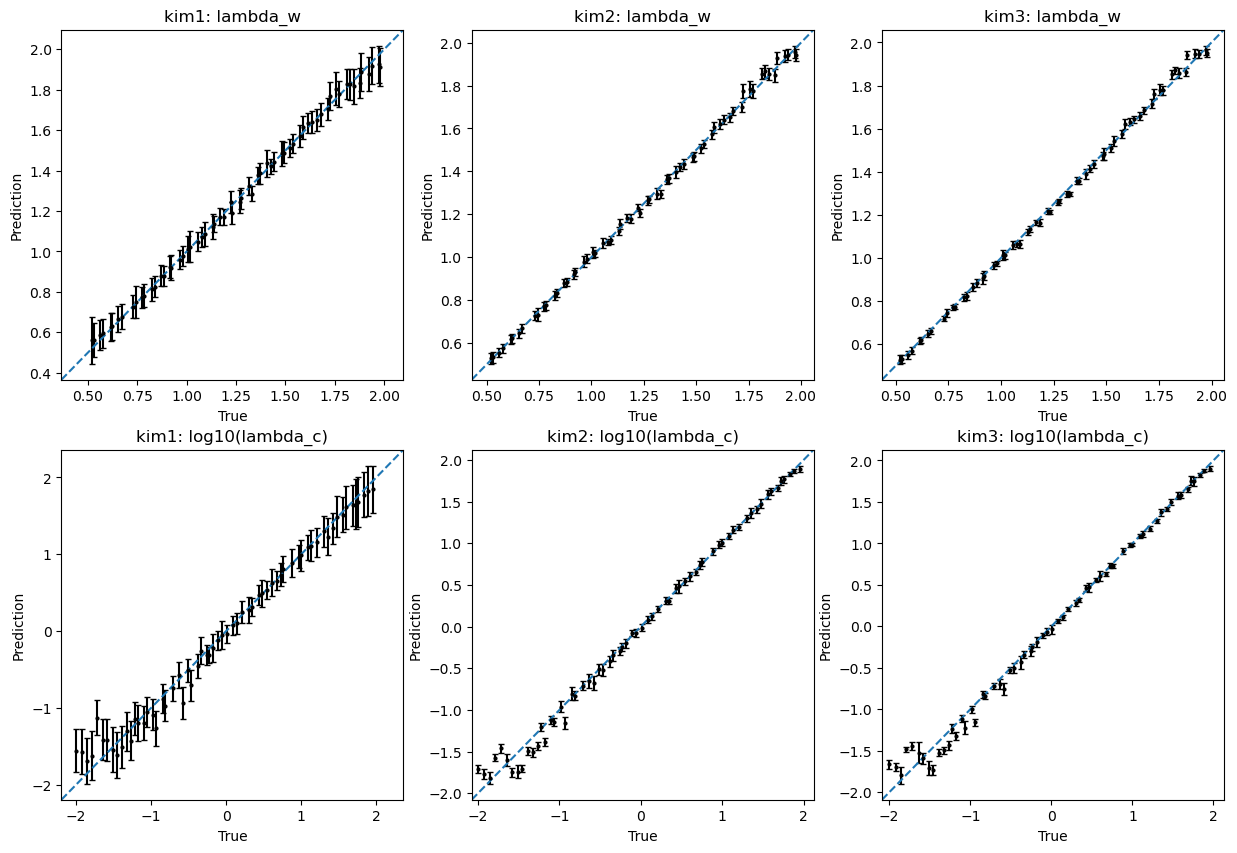

In [27]:
train_or_test = 'test'
fig, axes = plt.subplots(2,3,figsize=(15,10))
for i in range(2):
    y_var = y_vars[i]
    for j in range(3):
        model = labels[j]
        r = results[model]
        ax = axes[i,j]
        x = r['true'][train_or_test][...,i]
        y = r['weighted mean predict'][train_or_test][...,i]
        yens = r['ens predict'][train_or_test][...,i]
        w = r['weights'][...,i]
        std = np.sqrt(np.average((yens-y)**2, weights=w, axis=0))
        ax.errorbar(x, y, std, color='black', linestyle='None', fmt='o', markersize=2, capsize=2)
        lim = ax.get_ylim()
        ax.plot(lim, lim, '--', color='tab:blue')
        ax.set(xlim=lim, ylim=lim, xlabel='True', ylabel='Prediction', title=f"{model}: {y_var}")


## Performance boxplots

: 

# Plot the mapping results

: 